In [1]:
import matplotlib.pyplot as plt
import numpy as np
import json
import seaborn as sns
import pandas as pd
import os

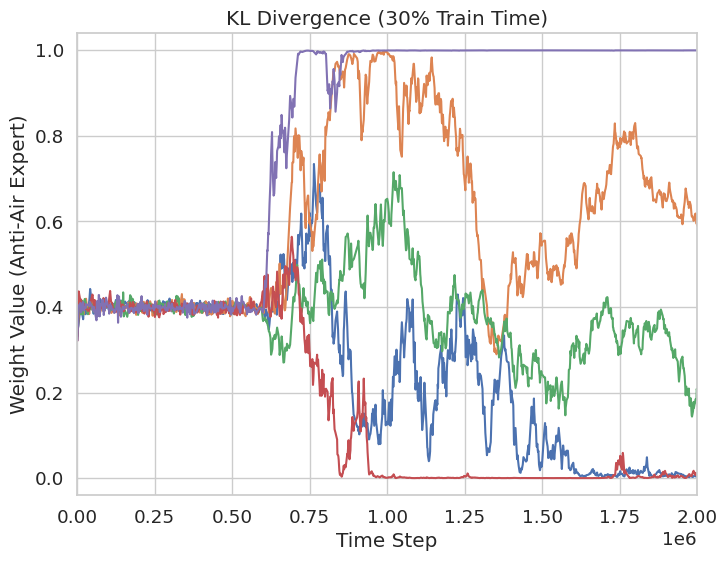

In [33]:
# Plot training data against each other
sns.set_theme(style="whitegrid", font_scale=1.2)
plt.figure(figsize=(8,6))
plots_paths = [
    "final_fusion_policies/soft_weights_kl_frac_0-3/tb_data/seed_0_aa_rate.json",
    "final_fusion_policies/soft_weights_kl_frac_0-3/tb_data/seed_100_aa_rate.json",
    "final_fusion_policies/soft_weights_kl_frac_0-3/tb_data/seed_300_aa_rate.json",
    "final_fusion_policies/soft_weights_kl_frac_0-3/tb_data/seed_500_aa_rate.json",
    "final_fusion_policies/soft_weights_kl_frac_0-3/tb_data/seed_800_aa_rate.json",
]
labels = [
    "Seed 0",
    "Seed 100",
    "Seed 300",
    "Seed 500",
    "Seed 800",
]
for idx, path in enumerate(plots_paths):
    with open(path) as f:
        results = json.load(f)
        df = pd.DataFrame(results, columns=["col0", "x", "y"])
        df["y"] /= 100
        line = sns.lineplot(data=df, x="x", y="y", errorbar="sd", label=labels[idx], legend=False)
handles, legend_labels = line.get_legend_handles_labels()
plt.xlabel("Time Step")
plt.ylabel("Weight Value (Anti-Air Expert)")
plt.ylim((-0.04,1.04))
plt.xlim((0, 2_000_000))
plt.title("KL Divergence (30% Train Time)")
# Save legend separately for report
# fig_leg = plt.figure(figsize=(1.7, 1.5))
# fig_leg.legend(handles, legend_labels, loc="center", ncol=1)
# fig_leg.savefig("legends/kl_0-5_legend.png", dpi=600)
# plt.close(fig_leg)
plt.show()

In [ ]:
# Print transfer metrics: jumpstart, asymptotic, transfer ratio
results_paths = [
    "averaged_tb_data/ppo_reward_seeds-5.json",
    "averaged_tb_data/sequential_reward_seeds-5.json",
    "averaged_tb_data/rl_teacher_obs_reward_seeds-5.json",
    "averaged_tb_data/fusenet_reward_seeds-5.json",
]
jumpstarts = []
asymptotics = []
aucs = []
runs = [f"run{i+1}" for i in range(5)]
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        df = pd.DataFrame(data=results)
        grouped_df = [x for _, x in df.groupby(df["x"])]
        df_x = [grouped_df[i]["x"].mean() for i in range(len(grouped_df))]
        df_y = [grouped_df[i]["y"].mean() for i in range(len(grouped_df))]
        jumpstarts.append(df_y[0].item())
        asymptotics.append(df_y[-1].item())
        aucs.append(np.trapezoid(df_y, df_x).item())
print(jumpstarts)
print(asymptotics)
aucs = [
    (aucs[i] - aucs[0]) / aucs[0]
    for i in range(1,len(aucs))
]
print(aucs)

[-0.5012420986599999, 0.67329201698, -0.19503089889999997, -0.33291940762000005]
[1.7659875869600001, 1.71463356018, 1.57463352682, 1.2978385209999999]
[0.0339038184658459, -0.23686577490806446, -0.1590396007029476]


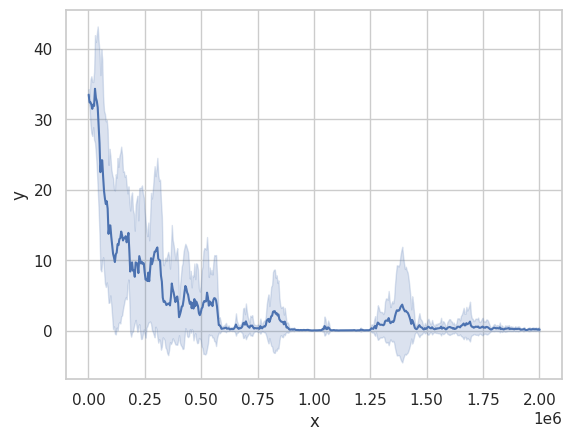

In [25]:
# Average data over multiple training sessions
def to_df(data, run_id):
    return pd.DataFrame(data, columns=['col0', 'x', 'y']).assign(run=run_id)

sns.set_theme(style="whitegrid")
plots_paths = [
    "final_fusion_policies/soft_weights/tb_data/seed_0_def_rate.json",
    "final_fusion_policies/soft_weights/tb_data/seed_100_def_rate.json",
    "final_fusion_policies/soft_weights/tb_data/seed_300_def_rate.json",
    "final_fusion_policies/soft_weights/tb_data/seed_500_def_rate.json",
    "final_fusion_policies/soft_weights/tb_data/seed_800_def_rate.json",
]
runs = []
for i, path in enumerate(plots_paths):
    with open(path) as f:
        results = json.load(f)
        runs.append(to_df(results, f"run{i}"))

all_x = pd.concat([df['x'] for df in runs])
x_common = np.linspace(all_x.min(), all_x.max(), 500)
interpolated_dfs = []
for df in runs:
    interp_y = np.interp(x_common, df['x'], df['y'])
    interpolated_dfs.append(pd.DataFrame({'x': x_common, 'y': interp_y}))
for i, df in enumerate(interpolated_dfs):
    df['run'] = f'run{i+1}'
df_all = pd.concat(interpolated_dfs, ignore_index=True)
save_dir = "averaged_tb_data"
os.makedirs(save_dir, exist_ok=True)
file_name = "fusenet_def_rate_seeds-5.json"
df_all.to_json(
    path_or_buf=os.path.join(save_dir, file_name),
    orient="records",
    lines=False,
    indent=2,
)
sns.lineplot(data=df_all, x="x", y="y", errorbar="sd")
plt.show()

In [ ]:
# Plot box plots of evaluation results
results_paths = [
    "base_policies/ryu_vanilla/evaluations/seed_0/det_arcade/results.json",
    "base_policies/ryu_vanilla/evaluations/seed_0/sto_arcade/results.json",
    "base_policies/rl_teacher_obs/evaluations/seed_0/deterministic/results.json",
    "base_policies/rl_teacher_obs/evaluations/seed_0/stochastic/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_0/soft_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_0/hard_weights_det/results.json",
]
reward_infos = []
stages_infos = []
# arcade_infos = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        reward_infos.append(results["rewards_infos"])
        stages_infos.append(results["stages_infos"])
        # arcade_infos.append(results["arcade_runs_infos"])
all_results = [reward_infos, stages_infos]
titles = ["Rewards", "No. of Stages Completed", "No. of Arcade Runs Completed"]
colors = ["tab:blue","tab:green","tab:orange","tab:olive","tab:cyan","tab:purple","tab:brown","tab:pink","tab:gray"]
x_tick_labels = [
    "Baseline PPO\n(Deterministic)",
    "Baseline PPO\n(Stochastic)",
    "PPO with \nTeacher Action\nOberservations\n(Deterministic)",
    "PPO with \nTeacher Action\nOberservations\n(Stochastic)",
    "FuseNet\n(Soft-Weights)",
    "FuseNet\n(Hard-Weights)",
]
for idx, results in enumerate(all_results):
    fig = plt.figure(figsize=(10,7))
    ax = fig.add_subplot(111)
    bp = ax.boxplot(
        results,
        patch_artist=True,
        notch=False,
        vert=0
    )
    for patch, color in zip(bp["boxes"], colors):
        patch.set_facecolor(color)
    for median in bp["medians"]:
        median.set(color="tab:red", linewidth=2)
    ax.set_title(titles[idx])
    ax.set_xticklabels(x_tick_labels)
    ax.grid()
    plt.show()

In [ ]:
# Average out multiple student-teacher action similarity scores
results_paths = [
    "final_fusion_policies/soft_weights/evaluations/seed_0/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_100/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_300/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_500/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_800/hard_weights_det/results.json",
]

# Preprocessing to make dicts with the same shapes as the results json files
with open(results_paths[0]) as f:
    results = json.load(f)
    averaged_results = {
        "teacher_likelihood_means": {
            k: [[0] for _ in range(2)]
            for k in results["teacher_likelihood_means"].keys()
        },
        "teacher_likelihood_stds": {
            k: [[0] for _ in range(2)]
            for k in results["teacher_likelihood_stds"].keys()
        },
    }

for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        for key in results["teacher_likelihood_means"].keys():
            for idx in range(2):
                averaged_results["teacher_likelihood_means"][key][idx][0] += results["teacher_likelihood_means"][key][idx][0]
                
        for key in results["teacher_likelihood_stds"].keys():
            for idx in range(2):
                averaged_results["teacher_likelihood_stds"][key][idx][0] += results["teacher_likelihood_stds"][key][idx][0]

for key in results["teacher_likelihood_means"].keys():
    for idx in range(2):
        averaged_results["teacher_likelihood_means"][key][idx][0] /= len(results_paths)
        
for key in results["teacher_likelihood_stds"].keys():
    for idx in range(2):
        averaged_results["teacher_likelihood_stds"][key][idx][0] /= len(results_paths)

# Save to json file
save_dir = "averaged_sim_data"
os.makedirs(save_dir, exist_ok=True)
file_name = "hard_weights_seeds-5.json"
with open(os.path.join(save_dir, file_name), "w") as f:
    json.dump(averaged_results, f, indent=4)

In [11]:
# Print student-teacher action similarity metrics
results_paths = [
    "averaged_sim_data/hard_weights_seeds-5.json",
]
teacher_sim_means = []
teacher_sim_stds = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        teacher_sim_means.append(results["teacher_likelihood_means"])
        teacher_sim_stds.append(results["teacher_likelihood_stds"])

for s_idx, means_and_stds in enumerate(zip(teacher_sim_means, teacher_sim_stds)):
    means, stds = means_and_stds
    print("-----------------------------------------------------------------")
    for t_id in means.keys():
        print(f"\nAvg likelihood of student {s_idx + 1} picking the same action as {t_id}:")
        act_means = means[t_id]
        act_stds = stds[t_id]
        for a_idx, act_info in enumerate(zip(act_means, act_stds)):
            act_mean, act_std = act_info
            act_mean = round(act_mean[0] * 100, 3)
            act_std = round(act_std[0] * 100, 3)
            print(f"Action {a_idx}: {act_mean}% +/- {act_std}")
    print("\n-----------------------------------------------------------------")

-----------------------------------------------------------------

Avg likelihood of student 1 picking the same action as antiair_teacher:
Action 0: 0.0% +/- 0.0
Action 1: 0.0% +/- 0.0

Avg likelihood of student 1 picking the same action as attack_teacher:
Action 0: 100.0% +/- 0.0
Action 1: 100.0% +/- 0.0

Avg likelihood of student 1 picking the same action as defence_teacher:
Action 0: 0.0% +/- 0.0
Action 1: 0.0% +/- 0.0

-----------------------------------------------------------------


In [ ]:
# Print student-teacher KL-divergence metrics
results_paths = [
    "final_fusion_policies/soft_weights/evaluations/seed_0/hard_weights_det/results.json",
    "final_fusion_policies/soft_weights/evaluations/seed_0/soft_weights_det/results.json",
]
kl_divs = []
kl_means = []
kl_stds = []
for path in results_paths:
    with open(path) as f:
        results = json.load(f)
        kl_divs.append(results["kl_divergences"])
        kl_means.append(results["mean_kl_divs"])
        kl_stds.append(results["std_kl_divs"])
        
print("----------------------------------------------------------------")
for s_idx, means_and_stds in enumerate(zip(kl_means, kl_stds)):
    means, stds = means_and_stds
    for t_id in means.keys():
        print(f"KL divergence between student {s_idx + 1} and {t_id}: {means[t_id]:.3f} +/- {stds[t_id]:.5f}")
    print("----------------------------------------------------------------")